In [1]:
from scipy.integrate import quad
from scipy.optimize import minimize, root_scalar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functions # function to help us compute the prices

In [3]:
# Load the data
data = pd.read_csv('Project-Data.csv')

# Extract data
maturities = data['Maturity'].values
observed_yields = data[' ZCYield'].values
observed_futures_prices = data[' FuturesPrice'].values

In [4]:
# Given volatility
sigma_r = 0.00023
# Initial spot price of oil
O_0 = 80

# Methodology

For questions 18 (and 19), we calibrate the parameters by minimizing the Mean Squared Error (MSE) of the observed yields (futures prices) with the calibrated yields (futures prices).

Afterwards, we verify the accuracy of the calibration by computing several metrics : SSE, RMSE, MAE and R^2. 

# Question 18

We define an objective function to minimize. We chose the Mean Squared Error.

In [11]:
# Objective function for calibration
def squared_error(params, observed_yields, maturities, sigma_r):
    lambda_r, r_bar, r_0 = params
    errors = []
    for i in range(len(maturities)):
        tau = maturities[i]
        observed_yield = observed_yields[i]
        theoretical_yield =  - (functions.b_0(tau, lambda_r, r_bar, sigma_r) + functions.b_r(tau, lambda_r) * r_0) / tau
        errors.append((observed_yield - theoretical_yield)**2)
    return np.sum(errors)

def mse(params, observed_yields, maturities, sigma_r):
    return squared_error(params, observed_yields, maturities, sigma_r) / len(maturities)

We calibrate by minimizing the Mean Square error between real values and computed values.

In [15]:
# Initial guess for the parameters
#initial_guess = [0.1, 0.05, 0.03]
initial_guess = [0.1, 0.05, 0.04]

# Perform the calibration
result = minimize(mse, initial_guess, args=(observed_yields, maturities, sigma_r), method='Nelder-Mead')


# Extract calibrated parameters
lambda_r_calibrated, r_bar_calibrated, r_0_calibrated = result.x

print("Calibrated parameters:")
print(f"lambda_r: {lambda_r_calibrated}")
print(f"r_bar: {r_bar_calibrated}")
print(f"r_0: {r_0_calibrated}")

Calibrated parameters:
lambda_r: 0.42486434416120067
r_bar: -0.010721343143568865
r_0: 0.014612546606659636


To verify our results, we compute diverse metrics including the R^2. As you can see, the calibration is precise.

In [6]:
# Assess the accuracy of the calibration
calibrated_yields = []
for tau in maturities:
    yield_calibrated = - (functions.b_0(tau, lambda_r_calibrated, r_bar_calibrated, sigma_r) + functions.b_r(tau, lambda_r_calibrated) * r_0_calibrated) / tau
    calibrated_yields.append(yield_calibrated)

data['Calibrated_Yield'] = calibrated_yields


# Calculate accuracy metrics
sse = np.sum((observed_yields - data['Calibrated_Yield'])**2)
rmse = np.sqrt(sse / len(observed_yields))
mae = np.mean(np.abs(observed_yields - data['Calibrated_Yield']))
r2 = 1 - (sse / np.sum((observed_yields - np.mean(observed_yields))**2))

print("Accuracy metrics:")
print(f"SSE: {sse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

Accuracy metrics:
SSE: 2.684243755822543e-07
RMSE: 0.00010803066705947624
MAE: 8.809744074475786e-05
R²: 0.9889945070326638


We finally plot the predicted yields against the real yields

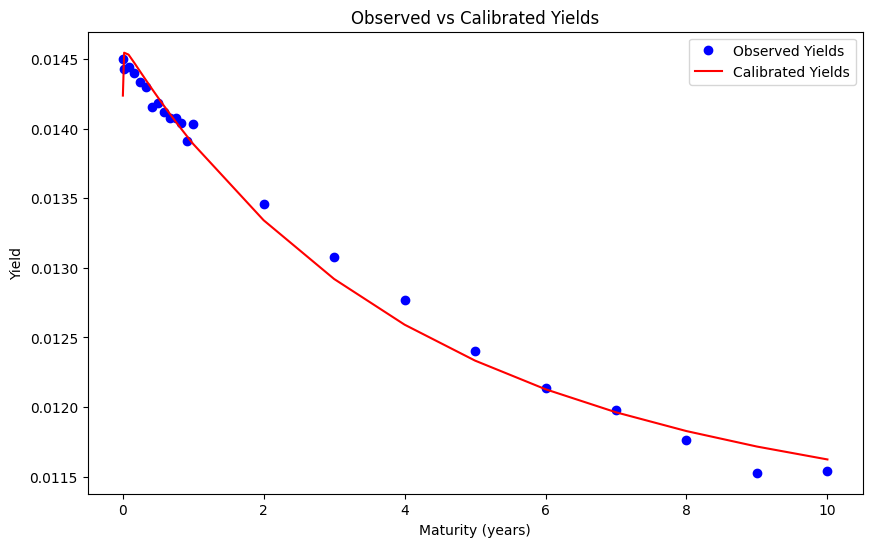

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(maturities, observed_yields, 'bo', label='Observed Yields')
plt.plot(maturities, calibrated_yields, 'r-', label='Calibrated Yields')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.legend()
plt.title('Observed vs Calibrated Yields')
plt.show()


The calibration results show a very high level of accuracy. The small values of SSE, RMSE, and MAE indicate minimal prediction errors. Additionally, the R² value of 0.989 suggests that our model explains 98.9% of the variance in the data. Therefore we can deduce that the model is accurate and reliable for predicting the dynamics.

# Question 19

Again we define an objective function to minimize

In [15]:
# Objective function for calibration
def objective(params, observed_futures_prices, maturities, O_0, r_0, lambda_r, r_bar):
    lambda_delta, delta_bar, delta_0 = params
    errors = []
    for i in range(len(maturities)):
        tau = maturities[i]
        observed_price = observed_futures_prices[i]
        theoretical_price = np.exp(
            functions.phi_0(tau, lambda_r, lambda_delta, r_bar, delta_bar) +
            functions.phi_r(tau, lambda_r) * r_0 +
            functions.phi_delta(tau, lambda_delta) * delta_0
        ) * O_0
        errors.append((observed_price - theoretical_price)**2)
    return np.sum(errors) / len(maturities)

In [16]:
# Initial guess for the parameters
initial_guess = [0.1, 0.05, 0.03]

# Perform the calibration
result = minimize(objective, initial_guess, args=(observed_futures_prices, maturities, O_0, r_0_calibrated, lambda_r_calibrated, r_bar_calibrated), method='Nelder-Mead')

# Extract calibrated parameters
lambda_delta_calibrated, delta_bar_calibrated, delta_0_calibrated = result.x

print("Calibrated parameters:")
print(f"lambda_delta: {lambda_delta_calibrated}")
print(f"delta_bar: {delta_bar_calibrated}")
print(f"delta_0: {delta_0_calibrated}")


Calibrated parameters:
lambda_delta: 0.5054689110381777
delta_bar: -0.030614394753573436
delta_0: 0.02004131401304637


In [17]:
# Calculate calibrated futures prices
calibrated_futures_prices = []
for tau in maturities:
    price_calibrated = np.exp(
        functions.phi_0(tau, lambda_r_calibrated, lambda_delta_calibrated, r_bar_calibrated, delta_bar_calibrated) +
        functions.phi_r(tau, lambda_r_calibrated) * r_0_calibrated +
        functions.phi_delta(tau, lambda_delta_calibrated) * delta_0_calibrated
    ) * O_0
    calibrated_futures_prices.append(price_calibrated)

data['Calibrated_FuturesPrice'] = calibrated_futures_prices

# Calculate accuracy metrics
sse = np.sum((observed_futures_prices - data['Calibrated_FuturesPrice'])**2)
rmse = np.sqrt(sse / len(observed_futures_prices))
mae = np.mean(np.abs(observed_futures_prices - data['Calibrated_FuturesPrice']))
r2 = 1 - (sse / np.sum((observed_futures_prices - np.mean(observed_futures_prices))**2))

print("Accuracy metrics:")
print(f"SSE: {sse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")


Accuracy metrics:
SSE: 0.005529408700800926
RMSE: 0.015505130568552667
MAE: 0.012400235824023793
R²: 0.9999872390129105


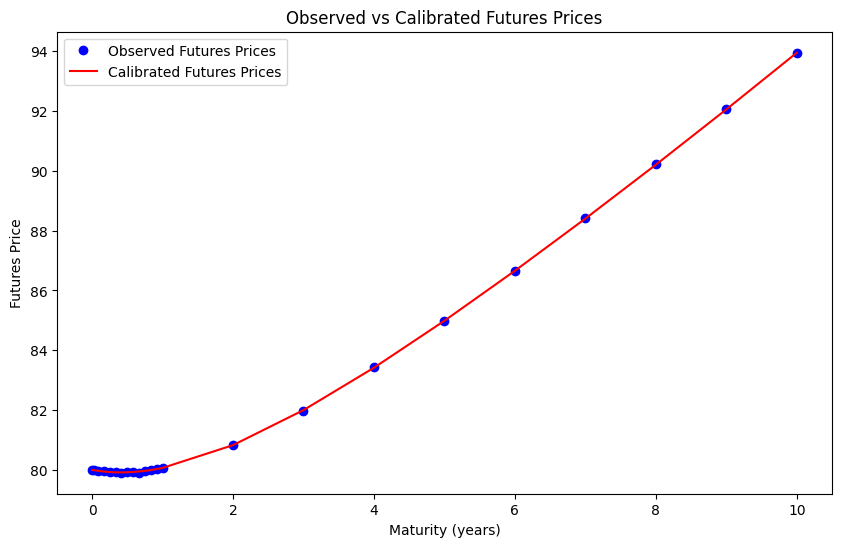

In [18]:
# Plot observed vs calibrated futures prices
plt.figure(figsize=(10, 6))
plt.plot(maturities, observed_futures_prices, 'bo', label='Observed Futures Prices')
plt.plot(maturities, calibrated_futures_prices, 'r-', label='Calibrated Futures Prices')
plt.xlabel('Maturity (years)')
plt.ylabel('Futures Price')
plt.legend()
plt.title('Observed vs Calibrated Futures Prices')
plt.show()

As for question 18, we get almost no errors. Therefore the model is really accurate in calibrating the dynamics